In [1]:
import csv
import cv2
import os
import numpy as np
from random import shuffle
import matplotlib.pyplot as plt
import imutils
from skimage import data, color, exposure
from sklearn import svm
import cPickle as pickle
import data_generator as dg
import multiscale_detect as md
import generate_sign as gs
%matplotlib inline  

Get data array from generate_data module. Randomize the array. Pick sample_size amount from each

Data is stored in a pickled zipped list of features and labels

In [2]:

#set parameters for hog
winSize = (80,80)
blockSize = (16,16)
blockStride = (8,8)
cellSize = (8,8)
nbins = 9
derivAperture = 1
winSigma = -1
histogramNormType = 0
L2HysThreshold = 2.0000000000000001e-01
gammaCorrection = 0
nlevels = 64
hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,
                        histogramNormType,L2HysThreshold,gammaCorrection,nlevels)


In [3]:
def getSingleLableFeatures(path, images, hog, dims, label, ignore=False):
    #check if pickle exists, load if so, 
    if os.path.isfile(path) and not ignore:  
        data = pickle.load(open(path, "rb"))      
        return data
    else:       
    #or generate the data and store the pickle
        data = []

        for img in images: 
            img = cv2.resize(img, dims)
            
            #for images with transparency layer, reduce to 3 layers
            if img.shape[2] > 3 :
                img = img[:,:,:3]

            feat = hog.compute(img)
            data.append((feat, label))

        pickle.dump(data, open(path, "wb"))
        return data


In [6]:
import kmeansutil as ku
images = dg.getImagesFromJSON(open("labels.json").read())
print images[:3]

clusters, images = ku.addClusterLabels(images)




[array([[[213, 194, 167],
        [213, 194, 167],
        [211, 192, 165],
        ..., 
        [218, 206, 178],
        [214, 201, 175],
        [211, 196, 170]],

       [[212, 193, 166],
        [212, 193, 166],
        [212, 193, 166],
        ..., 
        [215, 202, 176],
        [213, 200, 174],
        [210, 194, 171]],

       [[211, 192, 165],
        [212, 193, 166],
        [213, 195, 166],
        ..., 
        [203, 192, 165],
        [215, 201, 178],
        [216, 202, 180]],

       ..., 
       [[ 57,  65,  55],
        [ 57,  65,  55],
        [ 61,  69,  59],
        ..., 
        [206, 200, 181],
        [207, 201, 182],
        [202, 195, 176]],

       [[ 57,  64,  57],
        [ 52,  59,  52],
        [ 50,  58,  51],
        ..., 
        [204, 198, 179],
        [200, 194, 175],
        [202, 195, 176]],

       [[ 73,  80,  73],
        [ 74,  81,  74],
        [ 72,  80,  73],
        ..., 
        [201, 195, 176],
        [198, 192, 173],
        [204, 197

In [ ]:
image_size = 80
sample_size = 17772
train_size = 1600

In [70]:
# data = getTrainingDataFromDir("positive_real_cropped", 1)
# data.extend(getTrainingDataFromDir("sun_images",0, 500))

# data = getTrainingDataFromScanning("alldata.pickle", hog, True)
# data.extend(artificialData)

shuffle(data)
#unzip data
features, labels = map(list, zip(*data))

# #need to flatten features, as each feature is in a list
features = [x.flatten() for x in features]
print len(features), len(labels)
sample_size = len(features)
train_size = int(round(.8*sample_size))


638 638


In [71]:
train_features = np.array(features[:train_size], np.float32)
test_features = np.array(features[train_size: sample_size], np.float32)
train_labels = np.array(labels[:train_size])
test_labels = np.array(labels[train_size:sample_size])

Train SVM

In [72]:
lsvm = svm.SVC(gamma=5, C=.1, kernel="linear")
lsvm.fit(train_features, train_labels)


SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=5, kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Compute and display training accuracy

In [73]:
print lsvm.score(train_features, train_labels)

0.998039215686


Compute and display test set accuracy, true and false positives, true and false negatives, list of files that were misclassified

In [74]:
#compute test accuracy
result = lsvm.predict(test_features)
print "test accuracy", lsvm.score(test_features, test_labels)
result = [int(x) for x in result]

false_positives = 0
false_negatives = 0
true_positives = 0
true_negatives = 0

false_pos_filenames = []
false_neg_filenames = []
true_pos_filenames = []
for i, row in enumerate(test_labels):
    if row  == 1 and result[i] == 1: 
        true_positives +=1
    if row  != 1 and result[i] != 1: 
        true_negatives +=1
    if row  != 1 and result[i] == 1: 
        false_positives +=1
    if row == 1 and result[i] != 1: 
        false_negatives +=1	


print "true positives:", true_positives, "true_negatives:", true_negatives, "false positives:", false_positives, "false_negatives:", false_negatives, "\n"




test accuracy 0.9765625
true positives: 24 true_negatives: 101 false positives: 1 false_negatives: 2 



Hard Negative Mining: scan negative images for false positives, store windows for retraining

In [76]:
#get dataset of negative images to scan through
neg_files = gs.getAllFiles("hwy_empty")
neg_imgs = []
false_pos_feat = []
signs = 0
nosigns = 0

for f in neg_files:
    neg_imgs.append([f, cv2.imread("hwy_empty/" + f)])

#checking contents
print len(neg_imgs)

#multiscale detect

import multiscale_detect as md
counter = 1
for row in neg_imgs:
    scales = md.pyramid(row[1], scale=1.5, minSize=(30, 30))
    winh = 80
    winw = 80
     
    for img in scales:
        results = []
 
        for (x, y, window) in md.sliding_window(img, 40, (winw, winh)):        
            if window.shape[0] != winh or window.shape[1] != winw:
                continue
            window = cv2.resize(window, (80, 80))
            feat = hog.compute(window)
            result = lsvm.predict(feat.reshape(1,-1))[0]
            if result == 1:  
                false_pos_feat.append(feat)
                signs +=1
            else:
                nosigns+=1
    counter +=1


print "signs", signs, "no signs", nosigns
false_pos_feat = [x.flatten() for x in false_pos_feat] 
print len(false_pos_feat)

67
signs 4288 no signs 51932
4288


In [77]:
false_pos_labels = [0] * len(false_pos_feat)


In [ ]:
#retrain classifier with false positives from hard negative mining
train_features_wfp = np.r_[train_features, np.array(false_pos_feat)]
train_labels_wfp = np.r_[train_labels, np.array(false_pos_labels)]
print train_features_wfp.shape, train_labels_wfp.shape

lsvm.fit(train_features_wfp, train_labels_wfp)
print "training accuracy", lsvm.score(train_features_wfp, train_labels_wfp)
#compute test accuracy
result = lsvm.predict(test_features)
print "test accuracy", lsvm.score(test_features, test_labels)
result = [int(x) for x in result]

false_positives = 0
false_negatives = 0
true_positives = 0
true_negatives = 0

false_pos_filenames = []
false_neg_filenames = []
true_pos_filenames = []
for i, row in enumerate(test_labels):
    if row  == 1 and result[i] == 1: 
        true_positives +=1
    if row  != 1 and result[i] != 1: 
        true_negatives +=1
    if row  != 1 and result[i] == 1: 
        false_positives +=1
    if row == 1 and result[i] != 1: 
        false_negatives +=1	

print "true positives:", true_positives, "true_negatives:", true_negatives, "false positives:", false_positives, "false_negatives:", false_negatives, "\n"
# print "false positives", false_pos_filenames, "\n"
# print "false negatives", false_neg_filenames, "\n"




(4798, 2916) (4798,)


Find and display signs in a test image

/home/mark/.local/lib/python2.7/site-packages/ipykernel/__main__.py:13: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


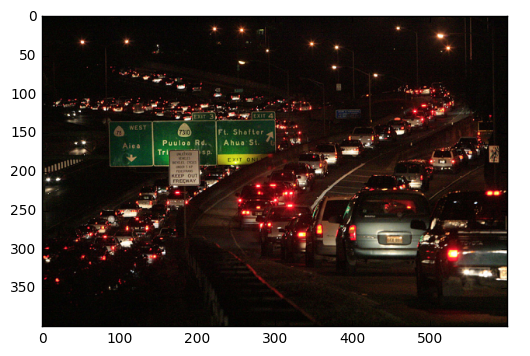

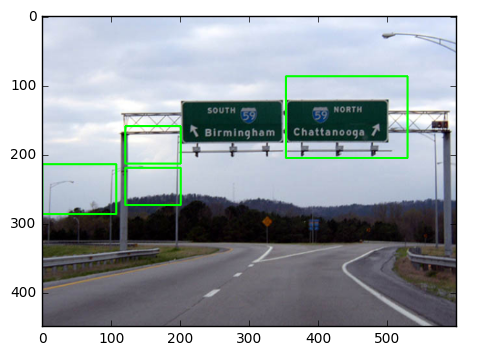

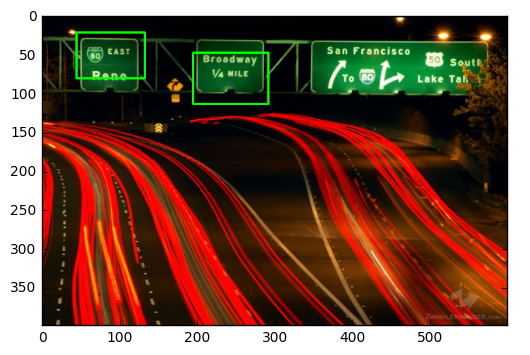

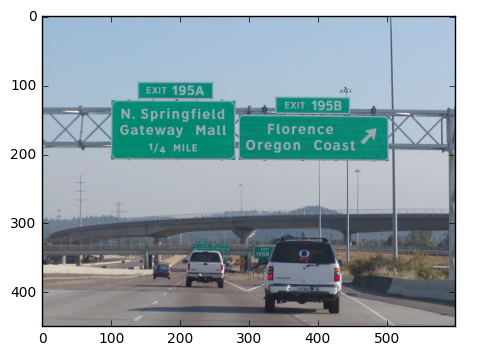

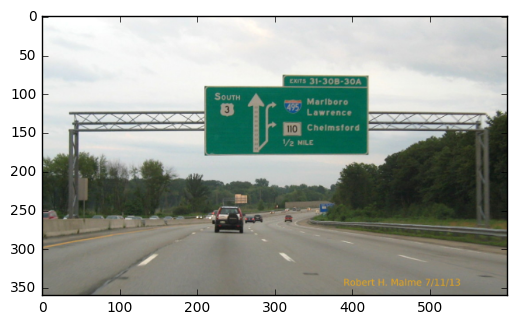

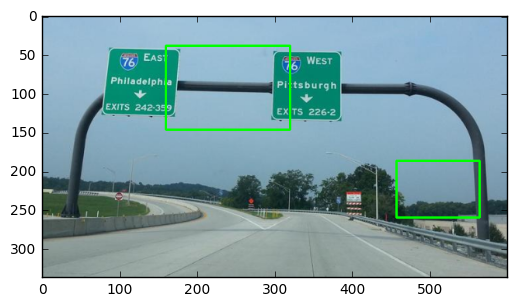

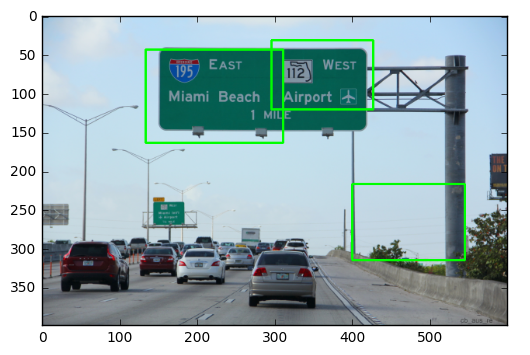

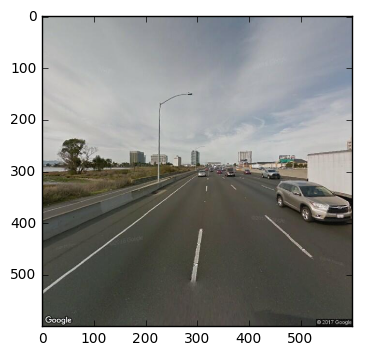

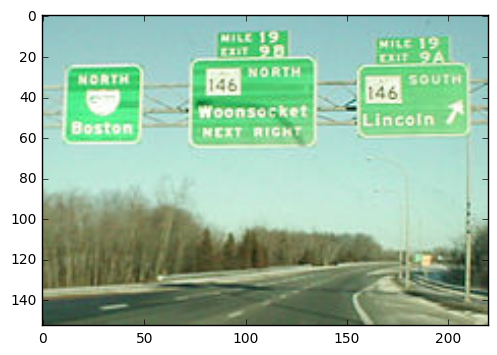

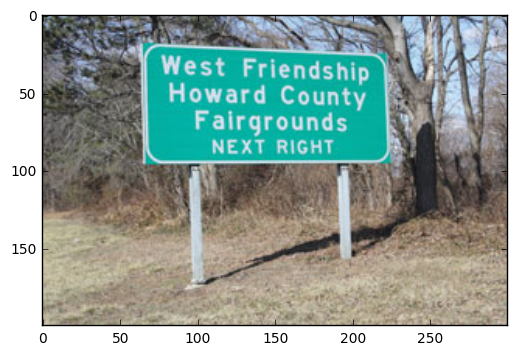

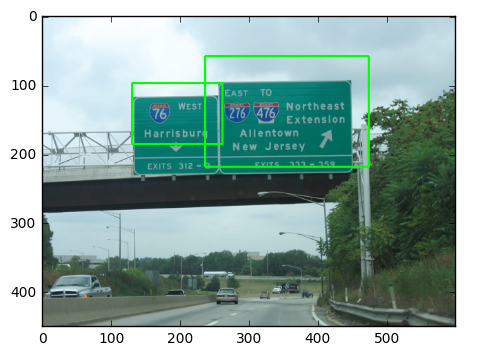

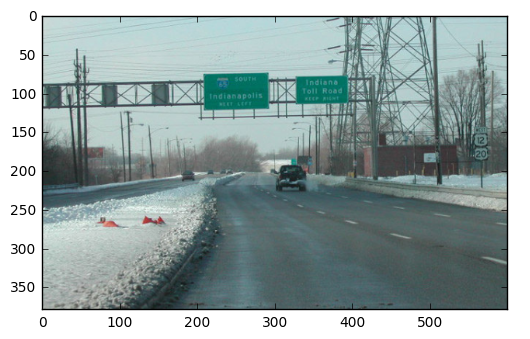

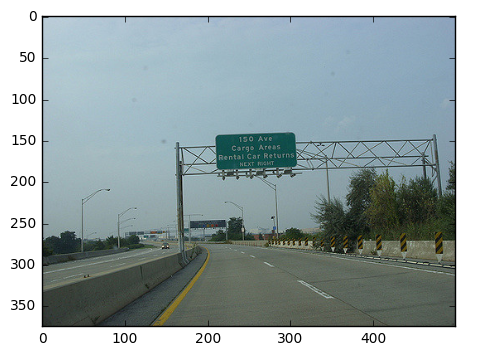

KeyboardInterrupt: 

In [63]:
def transform_scale(factor, boxes):
    return [(int(x1*factor), int(y1*factor), int(x2*factor), int(y2*factor)) for (x1,y1,x2,y2) in boxes]


import multiscale_detect as md
from random import randint
color = (0,255,0)
clone = None
dir = "multiscale_test"
files = os.listdir(dir)
for i in range(len(files)):
    test_image = cv2.imread(dir+"/"+files[i])
    if test_image != None and test_image.any():
        test_image = imutils.resize(test_image, width=min(600, test_image.shape[1]))
        clone = test_image.copy()
        clone = cv2.cvtColor(clone, cv2.COLOR_BGR2RGB)

        pscale = 1.1
        scales = md.pyramid(test_image, scale=pscale, minSize=(20, 20))
        winh = 54
        winw = 80
        scaled_results = []

        for i, img in enumerate(scales):
            results = []

            for (x, y, window) in md.sliding_window(img, 20, (winw, winh)):        
                if window.shape[0] != winh or window.shape[1] != winw:
                    continue
                wclone = img.copy()
                wclone = cv2.cvtColor(wclone, cv2.COLOR_BGR2RGB)
                window = cv2.resize(window, (80, 80))
                feat = hog.compute(window)
                result = lsvm.predict(feat.reshape(1,-1))[0]
                if result == 1:
                    results.append((x, y, x+winw, y+winh))

            factor = float(clone.shape[0])/img.shape[0]   
            scaled = transform_scale(factor, results)
            scaled_results.extend(scaled)


        scaled_results = md.non_max_suppression_fast(np.array(scaled_results), .3)
        for x1, y1, x2, y2 in scaled_results:
            cv2.rectangle(clone, (x1, y1), (x2, y2), color, 2)

        plt.imshow(clone)
        plt.show()
    else: print "Image not found"


# 